# Uplift modelling

Check out the chapter entitled "Uplift Modelling" in my book "Bayesuvius". https://github.com/rrtucci/Bayesuvius

This notebook contains excerpts from some notebooks in the software package https://github.com/maks-sh/scikit-uplift (scilift) See that repo for more illustrations of scilift usage.

scilift has various datasets to test itself with. This notebook is based on the X5_RetailHero dataset, except that we reduce that dataset to 1/100 the number of clients. This speeds things up and saves storage space, but gives poor statistics. To see the result for the full dataset which gives much better statistics, see the notebook:

https://github.com/maks-sh/scikit-uplift/blob/master/notebooks/uplift_model_selection_tutorial.ipynb


In [1]:
# this makes sure it starts looking for things from the scumpy folder down.
import os
import sys
os.chdir('../')
sys.path.insert(0,os.getcwd())
print(os.getcwd())

C:\Users\rrtuc\Desktop\backed-up\python-projects\uplift_rocket


In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd

pd.set_option('display.max_columns', None)
# %matplotlib inline

In [3]:
df_clients= pd.read_csv('data/small_clients.csv').set_index("client_id")
df_train = pd.read_csv('data/small_uplift_train.csv').set_index("client_id")
df_train = df_train[df_train.index.isin(df_clients.index)]
indices_test = pd.Index(set(df_clients.index) - set(df_train.index))
print("shape of df_clients=", df_clients.shape)
print("shape of df_train=", df_train.shape)
print('length of indices_test=', indices_test.shape)

shape of df_clients= (4001, 4)
shape of df_train= (1998, 2)
length of indices_test= (2003,)


In [4]:
# this converts date into integer number of seconds
df_features = df_clients.copy()
df_features['first_issue_time'] = \
    (pd.to_datetime(df_features['first_issue_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = \
    (pd.to_datetime(df_features['first_redeem_date'])
     - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] \
    - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [5]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']
print("X, y, treat shapes for train=", X_train.shape, y_train.shape, treat_train.shape)

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']
print("\nX, y, treat shapes for val=", X_val.shape, y_val.shape, treat_val.shape)


X_train_full = df_features.loc[df_train.index, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']
print("\nX, y, treat shapes for train_full=", X_train_full.shape, y_train_full.shape, treat_train_full.shape)


X_test = df_features.loc[indices_test, :]

cat_features = ['gender']

models_results = {
    'approach': [],
    'uplift@30%': []
}

X, y, treat shapes for train= (1398, 5) (1398,) (1398,)

X, y, treat shapes for val= (600, 5) (600,) (600,)

X, y, treat shapes for train_full= (1998, 5) (1998,) (1998,)


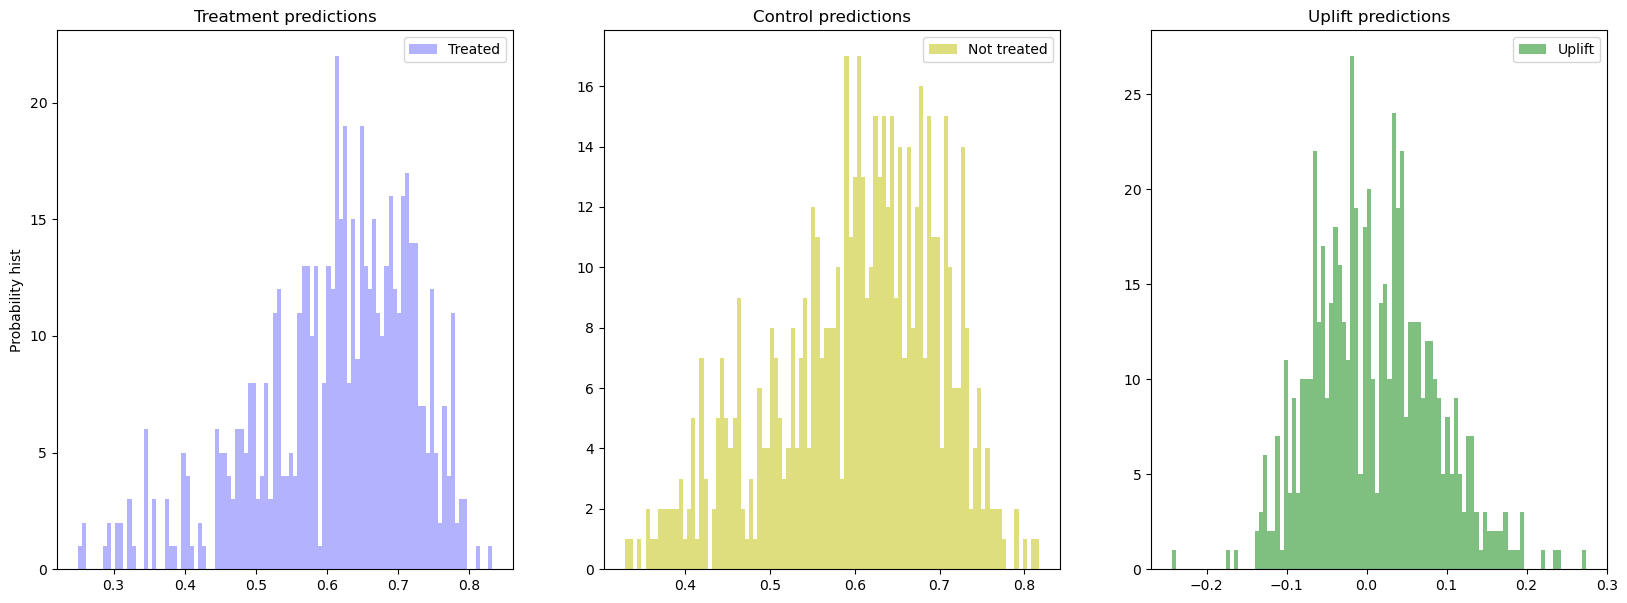

In [6]:
from sklift.metrics import uplift_at_k
# in sklift.viz, the functions check_matplotlib_support and 
# has  been moved from sklearn.utils to 
# sklearn.utils._optional_dependencies
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift supports all models, 
# that satisfy scikit-learn convention
# for example, let's use catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# get conditional probabilities (predictions) of performing the target action 
# during interaction for each object
sm_trmnt_preds = sm.trmnt_preds_
# And conditional probabilities (predictions) of performing the target action 
# without interaction for each object
sm_ctrl_preds = sm.ctrl_preds_

# draw the probability (predictions) distributions and their difference (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);


In [7]:
# You can also access the trained model with the same ease.
# For example, to build the importance of features:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,issue_redeem_delay,23.807792
1,first_issue_time,23.488607
2,first_redeem_time,19.232944
3,age,19.034715
4,treatment,11.083827
5,gender,3.352114


In [8]:
from sklift.metrics import uplift_by_percentile
import numpy as np

uplift_by_percentile(y_val.to_numpy(), 
                     uplift_sm, 
                     treat_val.to_numpy(), 
                     strategy='overall', 
                     total=True, 
                     std=True,
                     bins=10)

['total', 294, 306, 0.6700680272108843, 0.5980392156862745, 0.07202881152460983]


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,25,35,0.640000,0.657143,-0.017143,0.096000,0.080233,0.125113
10-20,29,31,0.724138,0.612903,0.111235,0.082996,0.087483,0.120589
20-30,31,29,0.806452,0.586207,0.220245,0.070958,0.091457,0.115756
30-40,27,33,0.740741,0.636364,0.104377,0.084337,0.083739,0.118849
40-50,26,34,0.769231,0.588235,0.180995,0.082629,0.084404,0.118116
50-60,33,27,0.666667,0.814815,-0.148148,0.082061,0.074757,0.111007
60-70,35,25,0.600000,0.440000,0.160000,0.082808,0.099277,0.129279
70-80,33,27,0.575758,0.555556,0.020202,0.086034,0.095629,0.128634
80-90,28,32,0.535714,0.500000,0.035714,0.094250,0.088388,0.129211


Had to introduce a temporary fix for `uplift_by_percetile()` 
Changed 
```
df.loc[-1, :] = ['total', 
        n_trmnt_total, 
        n_ctrl_total,
        response_rate_trmnt_total, 
        response_rate_ctrl_total, 
        response_rate_trmnt_total- response_rate_ctrl_total]
```
to
```
value= ['total', 
    n_trmnt_total[0], 
    n_ctrl_total[0],
    response_rate_trmnt_total[0], 
    response_rate_ctrl_total[0], 
    response_rate_trmnt_total[0] - response_rate_ctrl_total[0]]
    print(value)
    df.loc[-1, :] = np.array(value, dtype=object)
```



['total', 294, 306, 0.6700680272108843, 0.5980392156862745, 0.07202881152460983]


C:\Users\rrtuc\miniconda3\envs\uplift_rocket\Lib\site-packages\sklift\metrics\metrics.py:720: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'total' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[-1, :] = np.array(value, dtype=object)


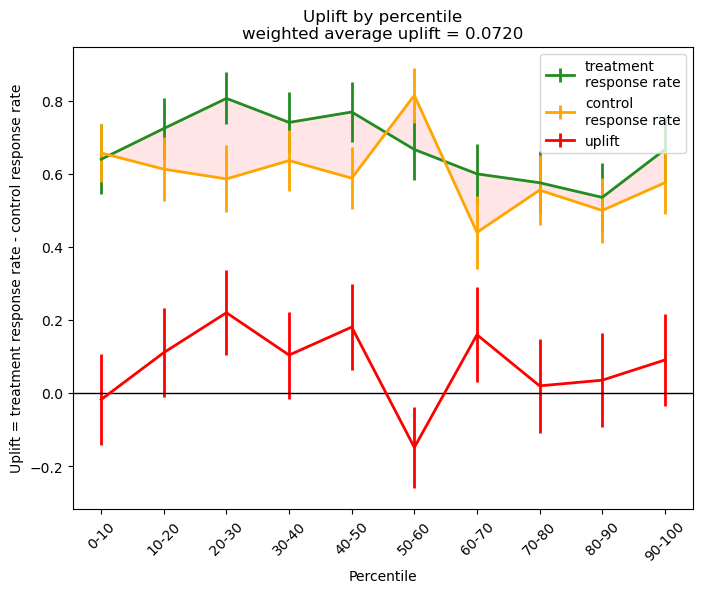

In [9]:
from sklift.viz import plot_uplift_by_percentile
import numpy as np

# line plot
plot_uplift_by_percentile(y_val, 
                          uplift_sm, 
                          treat_val, 
                          strategy='overall', 
                          kind='line');

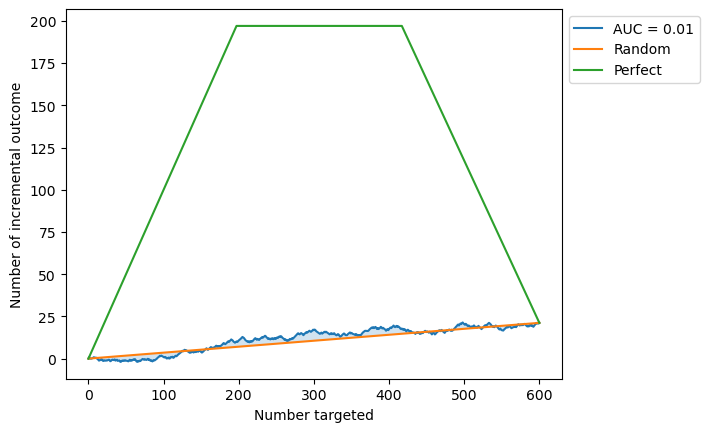

In [10]:
from sklift.viz import plot_qini_curve

# with ideal Qini curve (red line)
# perfect=True
plot_qini_curve(y_val, 
                uplift_sm, 
                treat_val, 
                perfect=True);